![ga4](https://www.google-analytics.com/collect?v=2&tid=G-6VDTYWLKX6&cid=1&en=page_view&sid=1&dl=statmike%2Fvertex-ai-mlops%2F02+-+Vertex+AI+AutoML&dt=02b+-+Vertex+AI+-+AutoML+with+clients+%28code%29.ipynb)

# 02b - Vertex AI - AutoML with clients (code)

Use the Vertex AI Python Client to recreate the no-code approach of (02a) with code (Python).  This builds a custom model with AutoML and deploys it to an Endpoint for predictions and explanations. 

### Prerequisites:
-  01 - BigQuery - Table Data Source

### Resources:
-  [Python Client for Vertex AI](https://googleapis.dev/python/aiplatform/latest/aiplatform.html)
-  [AutoML Tabular Training Job With Python Client](https://cloud.google.com/vertex-ai/docs/training/automl-api#aiplatform_create_training_pipeline_tabular_classification_sample-python)
-  [Interpreting Explanations](https://cloud.google.com/vertex-ai/docs/predictions/interpreting-results-automl#tabular)

### Conceptual Flow & Workflow
<p align="center">
  <img alt="Conceptual Flow" src="../architectures/slides/02b_arch.png" width="45%">
&nbsp; &nbsp; &nbsp; &nbsp;
  <img alt="Workflow" src="../architectures/slides/02b_console.png" width="45%">
</p>

---
## Setup

inputs:

In [4]:
project = !gcloud config get-value project
#PROJECT_ID = project[0]
PROJECT_ID = 'vertexai-demo1'

In [5]:
REGION = 'us-central1'
DATANAME = 'fraud'
NOTEBOOK = '02b'

# Resources
DEPLOY_COMPUTE = 'n1-standard-4'

# Model Training
VAR_TARGET = 'Class'
VAR_OMIT = 'transaction_id' # add more variables to the string with space delimiters

packages:

In [23]:
from google.cloud import aiplatform
from datetime import datetime

from google.cloud import bigquery
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value
import json
import numpy as np

clients:

In [24]:
aiplatform.init(project=PROJECT_ID, location=REGION)
bigquery = bigquery.Client()

parameters:

In [25]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
DIR = f"temp/{NOTEBOOK}"

environment:

In [8]:
!rm -rf {DIR}
!mkdir -p {DIR}

---
## Create Dataset (link to BigQuery table)

In [9]:
dataset = aiplatform.TabularDataset.create(
    display_name = f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}', 
    bq_source = f'bq://{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped',
    labels = {'notebook':f'{NOTEBOOK}'}
)

Creating TabularDataset
Create TabularDataset backing LRO: projects/31483342705/locations/us-central1/datasets/9116299395518693376/operations/3879614477821280256
TabularDataset created. Resource name: projects/31483342705/locations/us-central1/datasets/9116299395518693376
To use this TabularDataset in another session:
ds = aiplatform.TabularDataset('projects/31483342705/locations/us-central1/datasets/9116299395518693376')


---
## Train Model with AutoML

In [18]:
column_specs = list(set(dataset.column_names) - set(VAR_OMIT.split()) - set([VAR_TARGET, 'splits']))

In [19]:
column_specs = dict.fromkeys(column_specs, 'auto')

Define a Job:
- Consider Weighting
- Model Type
- Optimization Objective

https://googleapis.dev/python/aiplatform/latest/aiplatform.html#google.cloud.aiplatform.AutoMLTabularTrainingJob

In [21]:
tabular_classification_job = aiplatform.AutoMLTabularTrainingJob(
    display_name = f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}',
    optimization_prediction_type = 'classification',
    optimization_objective = 'maximize-au-prc',
    column_specs = column_specs,
    labels = {'notebook':f'{NOTEBOOK}'}
)

In [22]:
model = tabular_classification_job.run(
    dataset = dataset,
    target_column = VAR_TARGET,
    predefined_split_column_name = 'splits',
    #    training_fraction_split = 0.8,
    #    validation_fraction_split = 0.1,
    #    test_fraction_split = 0.1,
    budget_milli_node_hours = 1000,
    model_display_name = f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}',
    disable_early_stopping = False,
    model_labels = {'notebook':f'{NOTEBOOK}'}
)

View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/3966445453687390208?project=31483342705
AutoMLTabularTrainingJob projects/31483342705/locations/us-central1/trainingPipelines/3966445453687390208 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLTabularTrainingJob projects/31483342705/locations/us-central1/trainingPipelines/3966445453687390208 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLTabularTrainingJob projects/31483342705/locations/us-central1/trainingPipelines/3966445453687390208 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLTabularTrainingJob projects/31483342705/locations/us-central1/trainingPipelines/3966445453687390208 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLTabularTrainingJob projects/31483342705/locations/us-central1/trainingPipelines/3966445453687390208 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLTabularTrainingJob projects/31483342705/locations/us-central1/trainingPip

---
## Evaluation
While the model above was trained using AutoML with the API, it is still possible to review the evaluation metrics directly in the Google Cloud Console.  Just visit the Models section of Vertex AI service and select the model and it will present the evaluation metrics with many helpful visuals.

It is also possible to retrieve the evaluation metrics for you model using the API.  This section shows how to use the API.

For more information review [this page](https://cloud.google.com/vertex-ai/docs/training/evaluating-automl-models).

Setup a model client for the model create by this notebook:

In [26]:
model.resource_name

'projects/31483342705/locations/us-central1/models/8351822154865573888'

In [27]:
model_client = aiplatform.gapic.ModelServiceClient(
    client_options = {
        'api_endpoint' : f'{REGION}-aiplatform.googleapis.com'
    }
)

Retrives the aggregate model evalution metrics for the model as a whole.  First, use `.list_model_evaluations` to retrieve the evaluation id, then use `.get_model_evaluation` for the evaluation id:

In [28]:
evaluations = model_client.list_model_evaluations(parent = model.resource_name)
evals = iter(evaluations)
eval_id = next(evals).name
geteval = model_client.get_model_evaluation(name = eval_id)

Review several of the metrics include in the evaluation.  Also, compare these to the results in the console view.

In [29]:
geteval.metrics['auPrc']

0.9998601

In [30]:
for i in range(len(geteval.metrics['confusionMatrix']['annotationSpecs'])):
    print('True Label = ', geteval.metrics['confusionMatrix']['annotationSpecs'][i]['displayName'], ' has Predicted labels = ', geteval.metrics['confusionMatrix']['rows'][i])

True Label =  0  has Predicted labels =  [28279.0, 7.0]
True Label =  1  has Predicted labels =  [8.0, 39.0]


For models with labels you can retrieve the evaluation metrics for each slice of the model:

In [31]:
slices = model_client.list_model_evaluation_slices(parent = eval_id)

In [32]:
for slice in slices:
    print('Label = ', slice.slice_.value, 'has auPrc = ', slice.metrics['auPrc'])

Label =  0 has auPrc =  0.9998931
Label =  1 has auPrc =  0.89892423


---
## Endpoint and Deployment

In [33]:
endpoint = aiplatform.Endpoint.create(
    display_name = f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}',
    labels = {'notebook':f'{NOTEBOOK}'}
)

Creating Endpoint
Create Endpoint backing LRO: projects/31483342705/locations/us-central1/endpoints/233096465088512/operations/8548862128985997312
Endpoint created. Resource name: projects/31483342705/locations/us-central1/endpoints/233096465088512
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/31483342705/locations/us-central1/endpoints/233096465088512')


In [34]:
endpoint.deploy(
    model = model,
    deployed_model_display_name = f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}',
    traffic_percentage = 100,
    machine_type = DEPLOY_COMPUTE,
    min_replica_count = 1,
    max_replica_count = 1
)

Deploying Model projects/31483342705/locations/us-central1/models/8351822154865573888 to Endpoint : projects/31483342705/locations/us-central1/endpoints/233096465088512
Deploy Endpoint model backing LRO: projects/31483342705/locations/us-central1/endpoints/233096465088512/operations/5786466707547619328
Endpoint model deployed. Resource name: projects/31483342705/locations/us-central1/endpoints/233096465088512


---
## Prediction

### Prepare a record for prediction: instance and parameters lists

In [35]:
pred = bigquery.query(query = f"SELECT * FROM {DATANAME}.{DATANAME}_prepped WHERE splits='TEST' LIMIT 10").to_dataframe()

In [36]:
pred.head(4)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,transaction_id,splits
0,89138,-1.160093,1.031158,2.549458,2.239362,1.116877,0.932354,0.293081,0.445894,-1.721378,...,-0.436904,0.761667,0.710641,0.054423,0.007773,0.066995,0.0,0,f0f68f2f-844e-4a42-955c-635c6e487fcf,TEST
1,56291,1.212651,-0.507509,1.019939,-0.016309,-1.182505,-0.005955,-0.947555,0.325728,1.159265,...,0.038193,0.018386,0.061660,1.001295,-0.049728,-0.003026,0.0,0,47b75c71-efc3-497d-bafa-540deb857933,TEST
2,6538,1.139435,0.666018,0.999076,2.620147,-0.194133,-0.265980,-0.103196,-0.046573,0.311083,...,0.069927,0.454127,0.307426,-0.167981,-0.036667,0.010581,0.0,0,86084675-1a9b-457b-a114-04bab0848eba,TEST
3,121732,-1.866189,0.530582,-0.727456,-0.855107,2.169964,-1.588312,1.463897,-0.085754,-1.251841,...,-0.311277,-0.677299,1.803669,0.822689,-0.295855,-0.135467,0.0,0,7610d473-75b3-42f9-809d-7dfa694b486b,TEST


In [37]:
newob = pred[pred.columns[~pred.columns.isin(VAR_OMIT.split()+[VAR_TARGET, 'splits'])]].to_dict(orient='records')[0]
newob

{'Time': 89138,
 'V1': -1.1600929853435802,
 'V2': 1.03115814027421,
 'V3': 2.54945773658398,
 'V4': 2.2393622321291202,
 'V5': 1.1168768536230902,
 'V6': 0.932354389582821,
 'V7': 0.29308050964176696,
 'V8': 0.44589377122398494,
 'V9': -1.7213784585520802,
 'V10': 0.38410870972907496,
 'V11': 0.204008416772058,
 'V12': 0.357900891241851,
 'V13': 0.46137911105009494,
 'V14': -0.318158579751593,
 'V15': -1.9316766278711999,
 'V16': 1.48721136898099,
 'V17': -1.40071903532013,
 'V18': 0.583498846617402,
 'V19': -1.99835738239697,
 'V20': -0.0497223830332001,
 'V21': 0.28326511327626896,
 'V22': 0.647646239603879,
 'V23': -0.43690430897323795,
 'V24': 0.7616668035401759,
 'V25': 0.7106407552745571,
 'V26': 0.0544232129121311,
 'V27': 0.007773336073858191,
 'V28': 0.0669948572470503,
 'Amount': 0.0}

Need to understand the format of variables that the predictions expect.  AutoML may convert the type of some variables. The following cells retrieve the model from the endpoint and its schemata:

In [38]:
newob['Time'] = str(newob['Time'])

In [39]:
instances = [json_format.ParseDict(newob, Value())]
parameters = json_format.ParseDict({}, Value())

### Get Predictions: Python Client

In [40]:
prediction = endpoint.predict(instances=instances, parameters=parameters)

In [41]:
prediction

Prediction(predictions=[{'scores': [0.9988523125648499, 0.001147674163803458], 'classes': ['0', '1']}], deployed_model_id='6427459102955274240', model_version_id='1', model_resource_name='projects/31483342705/locations/us-central1/models/8351822154865573888', explanations=None)

In [42]:
prediction.predictions[0]['classes'][np.argmax(prediction.predictions[0]['scores'])]

'0'

### Get Predictions: REST

In [43]:
with open(f'{DIR}/request.json','w') as file:
    file.write(json.dumps({"instances": [newob]}))

In [44]:
!curl -X POST \
-H "Authorization: Bearer "$(gcloud auth application-default print-access-token) \
-H "Content-Type: application/json; charset=utf-8" \
-d @{DIR}/request.json \
https://{REGION}-aiplatform.googleapis.com/v1/{endpoint.resource_name}:predict

{
  "predictions": [
    {
      "classes": [
        "0",
        "1"
      ],
      "scores": [
        0.99885231256484985,
        0.001147674163803458
      ]
    }
  ],
  "deployedModelId": "6427459102955274240",
  "model": "projects/31483342705/locations/us-central1/models/8351822154865573888",
  "modelDisplayName": "02b_fraud_20230115055339",
  "modelVersionId": "1"
}


### Get Predictions: gcloud (CLI)

In [45]:
!gcloud beta ai endpoints predict {endpoint.name.rsplit('/',1)[-1]} --region={REGION} --json-request={DIR}/request.json

Using endpoint [https://us-central1-prediction-aiplatform.googleapis.com/]
[{'classes': ['0', '1'], 'scores': [0.9988523125648499, 0.001147674163803458]}]


---
## Explanations
Interpretation Guide
- https://cloud.google.com/vertex-ai/docs/predictions/interpreting-results-automl#tabular

In [46]:
explanation = endpoint.explain(instances=instances, parameters=parameters)

In [47]:
explanation.predictions

[{'classes': ['0', '1'], 'scores': [0.9988523125648499, 0.001147674163803458]}]

In [48]:
print("attribution:")
print("baseline output",explanation.explanations[0].attributions[0].baseline_output_value)
print("instance output",explanation.explanations[0].attributions[0].instance_output_value)
print("output_index",explanation.explanations[0].attributions[0].output_index)
print("output display value",explanation.explanations[0].attributions[0].output_display_name)
print("approximation error",explanation.explanations[0].attributions[0].approximation_error)

attribution:
baseline output 0.9999741911888123
instance output 0.9988523125648499
output_index [0]
output display value 0
approximation error 0.012661215798475772


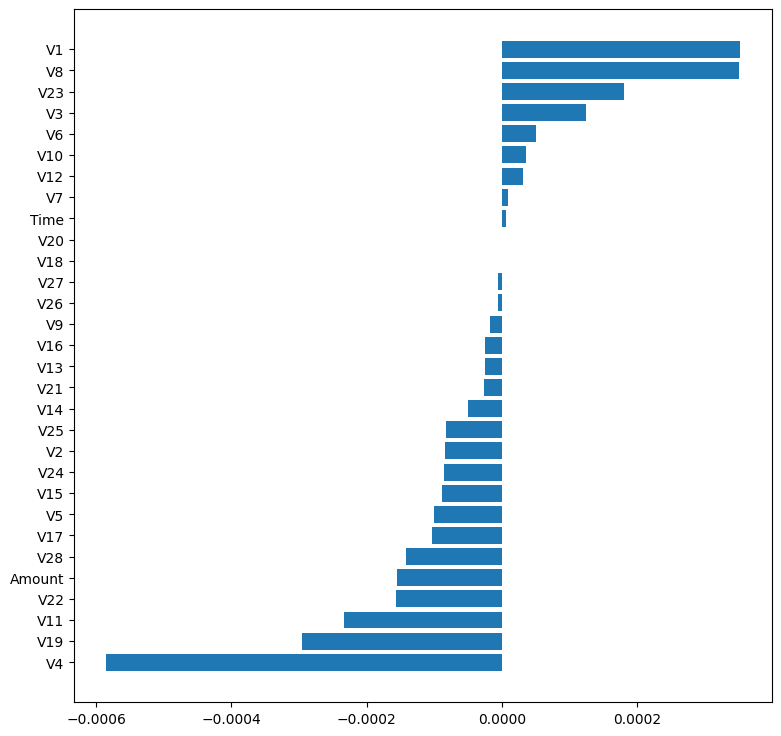

In [49]:
import matplotlib.pyplot as plt
features = []
scores = []
for k in explanation.explanations[0].attributions[0].feature_attributions:
    features.append(k)
    scores.append(explanation.explanations[0].attributions[0].feature_attributions[k])
features = [x for _, x in sorted(zip(scores, features))]
scores = sorted(scores)
fig, ax = plt.subplots()
fig.set_size_inches(9, 9)
ax.barh(features, scores)
fig.show()

---
## Batch Predictions: BigQuery Source to BigQuery Destination, with Explanations

In [ ]:
batch = aiplatform.BatchPredictionJob.create(
    job_display_name = f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}',
    model_name = model.name,
    instances_format = "bigquery",
    predictions_format = "bigquery",
    bigquery_source = f'bq://{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped',
    bigquery_destination_prefix = f"{PROJECT_ID}",
    generate_explanation = True,
    labels = {'notebook':f'{NOTEBOOK}'}
)

Creating BatchPredictionJob
BatchPredictionJob created. Resource name: projects/31483342705/locations/us-central1/batchPredictionJobs/6690683423595429888
To use this BatchPredictionJob in another session:
bpj = aiplatform.BatchPredictionJob('projects/31483342705/locations/us-central1/batchPredictionJobs/6690683423595429888')
View Batch Prediction Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/batch-predictions/6690683423595429888?project=31483342705
BatchPredictionJob projects/31483342705/locations/us-central1/batchPredictionJobs/6690683423595429888 current state:
JobState.JOB_STATE_RUNNING
BatchPredictionJob projects/31483342705/locations/us-central1/batchPredictionJobs/6690683423595429888 current state:
JobState.JOB_STATE_RUNNING
BatchPredictionJob projects/31483342705/locations/us-central1/batchPredictionJobs/6690683423595429888 current state:
JobState.JOB_STATE_RUNNING
BatchPredictionJob projects/31483342705/locations/us-central1/batchPredictionJobs/6690683

---
## Remove Resources
see notebook "99 - Cleanup"